# Changing laplacians

In [1]:
import os
import sys
#import time
import numpy as np

# -------------Torch-------------------
import torch
from torch.utils.data import DataLoader

# -------------Graph-------------------
import dgl
import networkx as nx
import matplotlib.pyplot as plt
sys.path.insert(0, "../lib/")
from utils import set_device
from laplacian import normalized_laplacian


%load_ext autoreload
%autoreload 2

# MNIST

In [2]:
# Downloads the dataset if not found locally
from dataset import check_mnist_dataset_exists, datasampler, MNISTDataset
_ = check_mnist_dataset_exists()

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data=640, nb_selected_test_data=2048
)

testset = MNISTDataset(test_data, test_labels)

## Convolution layer and classifier


In [3]:
from model import Classifier, SanityCheck, SmallCheb, DGL_stock_Classifier

from utils import collate



# Model definition for training

In [4]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = DGL_stock_Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
#if torch.cuda.is_available():
#    net.to(device)

DGL_stock_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=1, out_features=32, bias=False)
        (1): Linear(in_features=1, out_features=32, bias=False)
        (2): Linear(in_features=1, out_features=32, bias=False)
        (3): Linear(in_features=1, out_features=32, bias=False)
        (4): Linear(in_features=1, out_features=32, bias=False)
        (5): Linear(in_features=1, out_features=32, bias=False)
        (6): Linear(in_features=1, out_features=32, bias=False)
        (7): Linear(in_features=1, out_features=32, bias=False)
        (8): Linear(in_features=1, out_features=32, bias=False)
        (9): Linear(in_features=1, out_features=32, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=32, out_features=50, bias=False)
        (1): Linear(in_features=32, out_features=50, bias=False)
        (2): Linear(in_features=32, out_features=50, bias=False)
        (3): Linear

In [5]:
# LOAD MODEL

from utils import load_model
net.load_state_dict(load_model('Cheb_DGL_toshowDGL'))

<All keys matched successfully>

# Test

In [6]:
import sklearn
from sklearn.metrics import classification_report


def test_func(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        probs_Y = torch.cat((probs_Y, torch.softmax(net(bg, signal), 1)), 0)
        test_Y = torch.cat((test_Y, label.int()),0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    return sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4)

## Original lattice

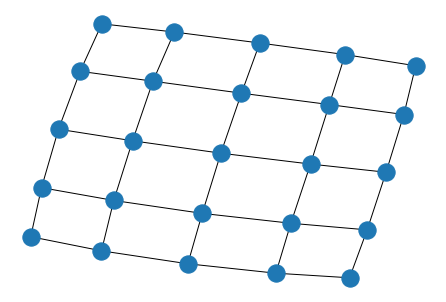

In [8]:
from graphs import regular_2D_lattice
g = regular_2D_lattice(5)
pos=nx.spring_layout(g.to_networkx().to_undirected())
nx.draw(g.to_networkx().to_undirected(),pos)

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


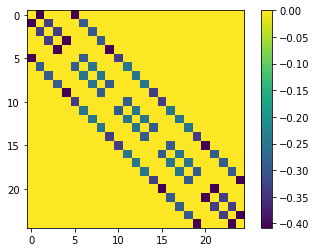

In [8]:
from ninja import Gspyplot, GeigplotH, GeigplotL

L = Gspyplot(g)

In [9]:
G = g.to_networkx().to_undirected()
L = nx.normalized_laplacian_matrix(G)

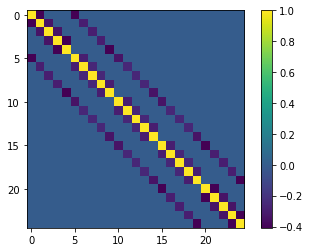

In [16]:
plt.imshow(L.todense())
plt.colorbar()

Largest eigenvalue: 2.0000000000000013
Smallest eigenvalue: 2.220446049250313e-16


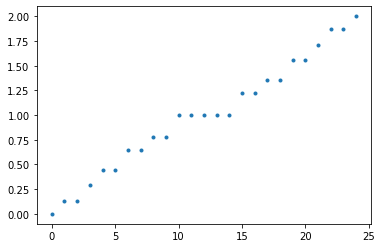

In [17]:
GeigplotL(g)

In [7]:
# Define a test function
data_loader_test = DataLoader(testset, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


              precision    recall  f1-score   support

           0     0.9351    0.9719    0.9532       178
           1     0.9835    0.9835    0.9835       242
           2     0.9266    0.9182    0.9224       220
           3     0.9031    0.9579    0.9297       214
           4     0.9585    0.9327    0.9455       223
           5     0.9448    0.9144    0.9293       187
           6     0.9358    0.9511    0.9434       184
           7     0.9109    0.8804    0.8954       209
           8     0.8808    0.8763    0.8786       194
           9     0.9031    0.8985    0.9008       197

    accuracy                         0.9292      2048
   macro avg     0.9282    0.9285    0.9282      2048
weighted avg     0.9294    0.9292    0.9291      2048



## Other lattice

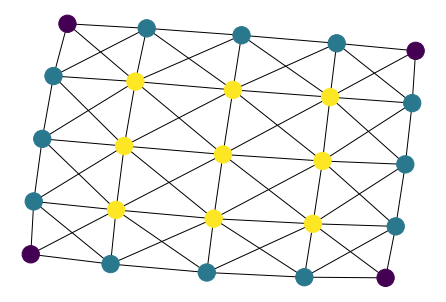

In [11]:
from graphs import regular_2D_lattice_8_neighbors

g2 = regular_2D_lattice_8_neighbors(5)
nx.draw(g2.to_networkx().to_undirected(),pos,node_color=np.array(g2.to_networkx().to_undirected().degree())[:,1],cmap=plt.cm.viridis)

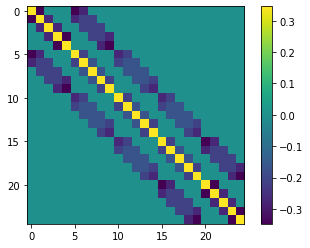

In [20]:
L2 = Gspyplot(g2)

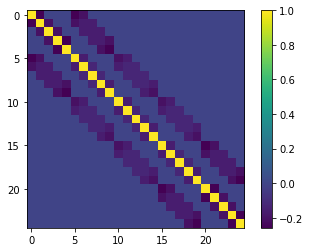

In [21]:
G = g2.to_networkx().to_undirected()
L = nx.normalized_laplacian_matrix(G)
plt.imshow(L.todense())
plt.colorbar()

Largest eigenvalue: 1.4858041353534703
Smallest eigenvalue: 5.551115123125783e-17


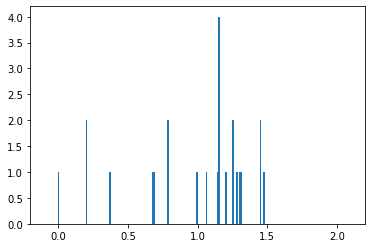

In [23]:
GeigplotH(g2)

In [8]:
testset_2 = MNISTDataset(test_data, test_labels, lattice_type=1)

# Define a test function
data_loader_test = DataLoader(testset_2, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9608    0.5506    0.7000       178
           1     0.0000    0.0000    0.0000       242
           2     0.6197    0.6591    0.6388       220
           3     0.5106    0.1121    0.1839       214
           4     0.8313    0.3094    0.4510       223
           5     0.8519    0.1230    0.2150       187
           6     0.9012    0.3967    0.5509       184
           7     0.8051    0.4545    0.5810       209
           8     0.1567    0.9845    0.2703       194
           9     0.3897    0.2690    0.3183       197

    accuracy                         0.3765      2048
   macro avg     0.6027    0.3859    0.3909      2048
weighted avg     0.5872    0.3765    0.3824      2048



In [14]:
testset_2 = MNISTDataset(test_data, test_labels, lattice_type=1)

def test_func2(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        probs_Y = torch.cat((probs_Y, torch.softmax(net(bg, signal, lambda_max = torch.ones(256)*2), 1)), 0)
        test_Y = torch.cat((test_Y, label.int()),0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    return sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4)

# Define a test function
data_loader_test = DataLoader(testset_2, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func2(data_loader_test))

              precision    recall  f1-score   support

           0     0.9457    0.9775    0.9613       178
           1     0.9955    0.9091    0.9503       242
           2     0.8739    0.9455    0.9083       220
           3     0.8514    0.8832    0.8670       214
           4     0.9330    0.8744    0.9028       223
           5     0.9371    0.7968    0.8613       187
           6     0.8852    0.8804    0.8828       184
           7     0.9235    0.8086    0.8622       209
           8     0.7154    0.9072    0.8000       194
           9     0.8227    0.8477    0.8350       197

    accuracy                         0.8833      2048
   macro avg     0.8883    0.8830    0.8831      2048
weighted avg     0.8905    0.8833    0.8844      2048



## Random supression

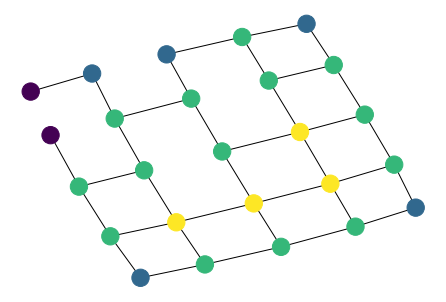

In [25]:
from graphs import random_edge_suppression

g3 = random_edge_suppression(5,5)
nx.draw(g3.to_networkx().to_undirected(), pos, node_color=np.array(
    g3.to_networkx().to_undirected().degree())[:, 1], cmap=plt.cm.viridis)

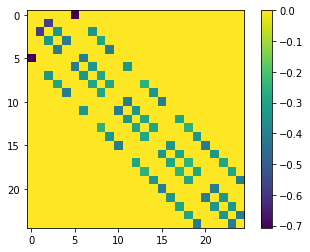

In [26]:
L3 = Gspyplot(g3)

Norm 1 distance: tensor(6.2154) 
Norm 2 distance: tensor(1.3157)


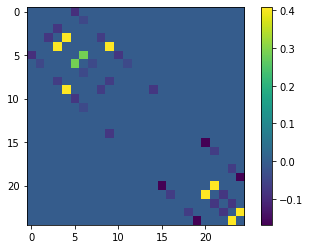

In [41]:
res = L3-L
print('Norm 1 distance:', torch.norm(res, p=1),
      '\nNorm 2 distance:', torch.norm(res, p=2))
plt.imshow(res.to_dense(), cmap='viridis')
plt.colorbar()

In [16]:
testset_3 = MNISTDataset(test_data, test_labels, lattice_type=2)

# Define a test function
data_loader_test = DataLoader(testset_3, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9351    0.9719    0.9532       178
           1     0.9835    0.9835    0.9835       242
           2     0.9346    0.9091    0.9217       220
           3     0.8982    0.9486    0.9227       214
           4     0.9500    0.9372    0.9436       223
           5     0.9348    0.9198    0.9272       187
           6     0.9459    0.9511    0.9485       184
           7     0.9113    0.8852    0.8981       209
           8     0.8724    0.8814    0.8769       194
           9     0.9119    0.8934    0.9026       197

    accuracy                         0.9287      2048
   macro avg     0.9278    0.9281    0.9278      2048
weighted avg     0.9289    0.9287    0.9286      2048



# Model trained on the 8 lattice

In [18]:
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [19]:
# LOAD MODEL trained on 8 neighbors

from utils import load_model
net.load_state_dict(load_model('Model_6000_20ep_8_lattice'))

<All keys matched successfully>

## Original lattice

In [20]:
testset = MNISTDataset(test_data, test_labels, lattice_type=0)

# Define a test function
data_loader_test = DataLoader(testset, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9167    0.5238    0.6667        42
           1     0.8961    1.0000    0.9452        69
           2     0.6623    0.9107    0.7669        56
           3     0.8636    0.3958    0.5429        48
           4     0.9655    0.5000    0.6588        56
           5     0.3770    0.8846    0.5287        52
           6     0.9130    0.4773    0.6269        44
           7     0.3643    0.9400    0.5251        50
           8     1.0000    0.1000    0.1818        40
           9     0.8000    0.0727    0.1333        55

    accuracy                         0.6074       512
   macro avg     0.7759    0.5805    0.5576       512
weighted avg     0.7714    0.6074    0.5763       512



## 8 lattice

In [21]:
testset_2 = MNISTDataset(test_data, test_labels, lattice_type=1)

# Define a test function
data_loader_test = DataLoader(testset_2, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9130    1.0000    0.9545        42
           1     1.0000    1.0000    1.0000        69
           2     0.9818    0.9643    0.9730        56
           3     0.9787    0.9583    0.9684        48
           4     0.9474    0.9643    0.9558        56
           5     0.9423    0.9423    0.9423        52
           6     0.9762    0.9318    0.9535        44
           7     0.9412    0.9600    0.9505        50
           8     0.9512    0.9750    0.9630        40
           9     0.9615    0.9091    0.9346        55

    accuracy                         0.9609       512
   macro avg     0.9593    0.9605    0.9596       512
weighted avg     0.9615    0.9609    0.9609       512



## Random suppresion

In [22]:
testset_3 = MNISTDataset(test_data, test_labels, lattice_type=2)

# Define a test function
data_loader_test = DataLoader(testset_3, batch_size=256,
                              shuffle=False, collate_fn=collate)
print(test_func(data_loader_test))

              precision    recall  f1-score   support

           0     0.9130    0.5000    0.6462        42
           1     0.8767    0.9275    0.9014        69
           2     0.6250    0.8929    0.7353        56
           3     0.8182    0.3750    0.5143        48
           4     0.9643    0.4821    0.6429        56
           5     0.3651    0.8846    0.5169        52
           6     0.9444    0.3864    0.5484        44
           7     0.3561    0.9400    0.5165        50
           8     0.7500    0.0750    0.1364        40
           9     0.8333    0.0909    0.1639        55

    accuracy                         0.5820       512
   macro avg     0.7446    0.5554    0.5322       512
weighted avg     0.7447    0.5820    0.5518       512



# Trying to know where the performance breaks down

In [23]:
# Using the 4-neighbors trained model

# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = testset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)
    
# LOAD MODEL

from utils import load_model
net.load_state_dict(load_model('Model_6000_20ep'))

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


<All keys matched successfully>

In [25]:
def test_func(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg)
        probs_Y = torch.cat((probs_Y, torch.softmax(net(bg, signal, L), 1)), 0)
        test_Y = torch.cat((test_Y, label.int()),0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    return sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4, output_dict=True)

In [26]:
repz = []

for i in range(0,800,50):
    report = []
    for j in range(4):
        testset = MNISTDataset(test_data, test_labels, lattice_type=2, nb_removal=i)

        # Define a test function
        data_loader_test = DataLoader(testset, batch_size=256,
                                      shuffle=False, collate_fn=collate)
        
        report.append(test_func(data_loader_test)['accuracy'])
        
    repz.append(report)

In [29]:
import pandas as pd
df = pd.DataFrame(repz)

df['mean'] = df.mean(1)
df['std'] = df.std(1)
print(df)

           0         1         2         3      mean       std
0   0.962891  0.962891  0.962891  0.962891  0.962891  0.000000
1   0.964844  0.962891  0.960938  0.955078  0.960938  0.003654
2   0.962891  0.962891  0.957031  0.958984  0.960449  0.002537
3   0.931641  0.962891  0.957031  0.939453  0.947754  0.012686
4   0.923828  0.933594  0.943359  0.937500  0.934570  0.007109
5   0.898438  0.906250  0.935547  0.873047  0.903320  0.022290
6   0.908203  0.894531  0.861328  0.876953  0.885254  0.017707
7   0.826172  0.869141  0.830078  0.847656  0.843262  0.016992
8   0.863281  0.750000  0.746094  0.849609  0.802246  0.054432
9   0.734375  0.759766  0.664062  0.771484  0.732422  0.041684
10  0.642578  0.558594  0.732422  0.707031  0.660156  0.067163
11  0.613281  0.662109  0.539062  0.703125  0.629395  0.061086
12  0.626953  0.562500  0.597656  0.509766  0.574219  0.043651
13  0.587891  0.417969  0.533203  0.455078  0.498535  0.066268
14  0.365234  0.396484  0.453125  0.457031  0.417969  0

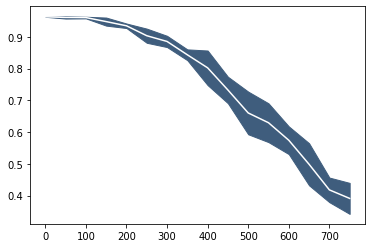

In [51]:
x = range(0,800,50)
plt.plot(x, df['mean'], color='white')
plt.fill_between(x, df['mean'] - df['std'],
                 df['mean'] + df['std'], color="#3F5D7D")
plt.title('Accuracy over number of removed edges')

In [43]:
print('the maximum removal rate is',750*100/3024,'% of all edges')

the maximum removal rate is 24.8015873015873 % of all edges


# Eigonvalue GUI

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider
import networkx as nx
import numpy
%matplotlib qt

from graphs import regular_2D_lattice, regular_2D_lattice_8_neighbors, random_edge_suppression

N = 7
g = regular_2D_lattice(N)

g2 = regular_2D_lattice_8_neighbors(N)

g3 = random_edge_suppression(N,N)


G2 = g2.to_networkx().to_undirected()
L2 = nx.normalized_laplacian_matrix(G2)
e = numpy.linalg.eigvals(L2.A)

fig, ax = plt.subplots()

s = np.sort(e)
l, = plt.plot(np.sort(nx.normalized_laplacian_spectrum(g.to_networkx().to_undirected()))) 
l, = plt.plot(np.sort(e), lw=2)

ax = plt.axis([0,len(e),-0.5,np.max(e)*1.5])

axamp = plt.axes([0.25, .03, 0.50, 0.02])
axamp2 = plt.axes([0.25, 0, 0.50, 0.02])
# Slider
samp = Slider(axamp, ' + b on diag', -1.5, 1.5, valinit=0)

samp2 = Slider(axamp2, 'Theta', -.5, 1.5, valinit=1)


def update(val):
    # amp is the current value of the slider
    amp = samp.val
    amp2 = samp2.val
    # update curve
    l.set_ydata(np.sort(numpy.linalg.eigvals((L2.todense()*amp2 +(numpy.eye(N*N)*amp)).A)))
    # redraw canvas while idle
    fig.canvas.draw_idle()

# call update function on slider value change
samp.on_changed(update)
samp2.on_changed(update)

plt.show()

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imagi

In [7]:
L2

<25x25 sparse matrix of type '<class 'numpy.float64'>'
	with 169 stored elements in Compressed Sparse Row format>